# Visualize rarefaction (k-mer accumulation curves) for most completely sequenced metagenomes per sample type

This notebook visualizes the top three most completely sequenced metagenomes per sample type for the metagenomes explored in this project.
We define most completely sequenced metagenomes as those with the highest ratio of deep sequencing to community complexity.
To estimate which samples were most completely sequenced, we calculated rarefaction (accumulation) curves using abundance information for subsampled k-mers from the raw metagenomes.
Because sequencing errors would 
Many rarefaction curve convergence detection methods rely on singleton and doubleton observations; since we removed all singleton k-mers, we characterized sequence completeness by measuring the average slope of the rarefaction curve. 
Curves with the lowest average slope should hae the most convergence (e.g. reach their asymptote, demonstrating that no or very few new k-mers are observed with the addition of more sequencing data).
This notebook grabs the three metagenomes per sample type with the lowest average slope and plots each rarefaction curves.
Using these plots, we then determine which sample types were most completely sequenced and thus would be the best candidates for more completely characterizing which samples were distinct to the metagenome.
Complete metagenome sequencing is important for identifying distinct metatranscriptome sequences because complete sequencing decreases the chances that a random transcript is sequenced that is from an organism truly in the community but whose genome was not captured because sequencing was not deep enough.

In [1]:
setwd("..")

In [2]:
# adjust plot size rendered inline
options(repr.plot.width = 8, repr.plot.height = 6, repr.plot.res = 300)

In [4]:
library(dplyr)
library(readr)
library(purrr)
library(tidyr)
library(ggplot2)
library(ggthemes)

## Read in metadata

In [5]:
metadata <- read_tsv("inputs/metadata-paired-mgx-mtx.tsv", show_col_types =  F) %>%
  mutate(subtract_pair = paste0(mtx_run_accession, "-minus-", mgx_run_accession))

## Read in slope summaries and filter to lowest mean slope per sample type

In [6]:
slopes <- Sys.glob("outputs/sourmash_sketch_downsample_filtered_rarecurves/rarecurve_slopes*") %>%
  map_dfr(read_tsv, show_col_types = F) %>%
  left_join(metadata, by = "mgx_run_accession")

In [7]:
slopes_filtered <- slopes %>%
  filter(mean_slope > 0) %>%
  group_by(sample_type) %>%
  slice_min(mean_slope, n = 3) %>%
  select(mgx_run_accession, mean_slope, min_nonzero_slope, mtx_run_accession, sample_type)

## Visualize rarefaction curves for most completely sequenced metagenomes per sample type

In [8]:
# read in raw rarefaction curve values
raw_rarecurve <- Sys.glob("outputs/sourmash_sketch_downsample_filtered_rarecurves/rarecurve_raw*") %>%
  map_dfr(read_tsv, show_col_types = F) %>%
  filter(mgx_run_accession %in% slopes_filtered$mgx_run_accession) %>%
  left_join(metadata, by = "mgx_run_accession")

### Plot complete rarefaction curves

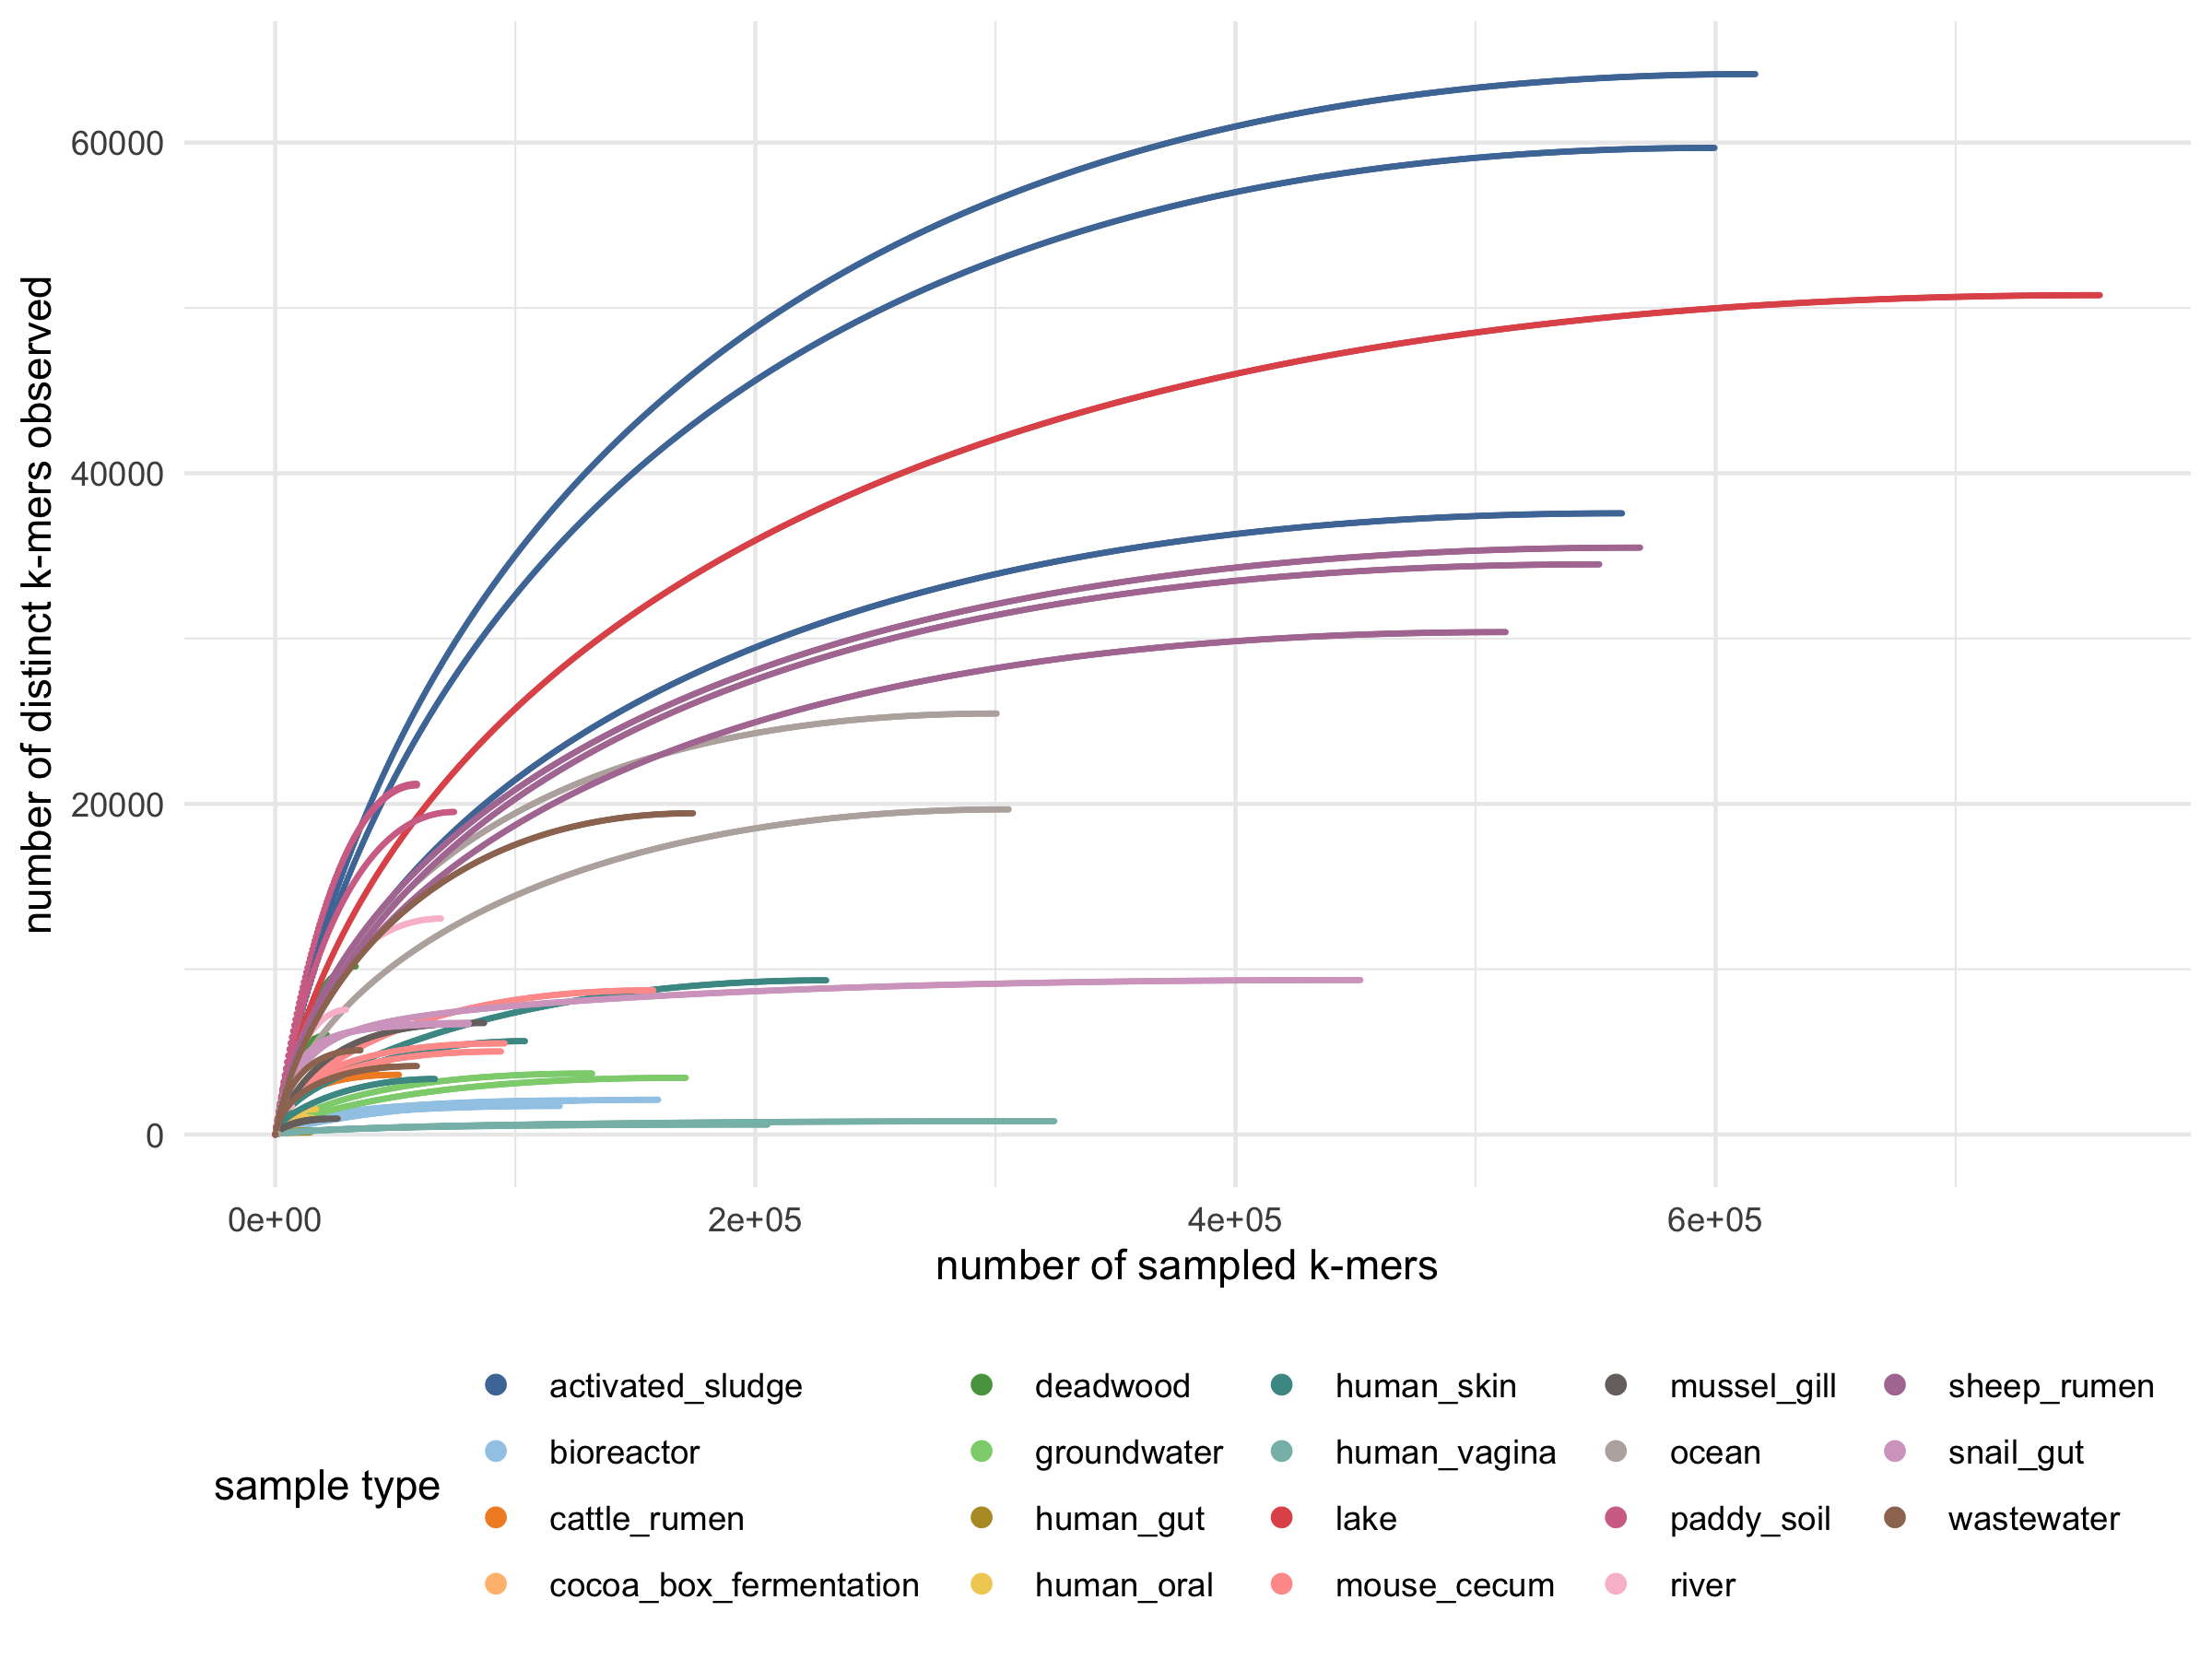

In [10]:
# subsample points for visualization; grab only 1 every 500 points
raw_rarecurve_filtered_500 <- raw_rarecurve %>%
  filter(num_kmers_sampled %% 500 == 1)

plt <- ggplot(raw_rarecurve_filtered_500, aes(x = num_kmers_sampled, y = num_kmers_observed, fill = mgx_run_accession, color = sample_type)) +
  geom_point(alpha = 1, size = .1) +
  theme_minimal() +
  theme(legend.position = "bottom") +
  guides(fill = "none", color = guide_legend(override.aes = list(size=2))) +
  scale_color_tableau(palette = "Tableau 20") +
  labs(x = "number of sampled k-mers", y = "number of distinct k-mers observed", color = "sample type")

plt

# uncomment for an interactive plot
# tmp <- plotly::ggplotly(plt)
# plotly::embed_notebook(tmp, height = '800px')

### Zoom in on origin to better separate curves

Warning message:
“Removed 53380 rows containing missing values (geom_point).”


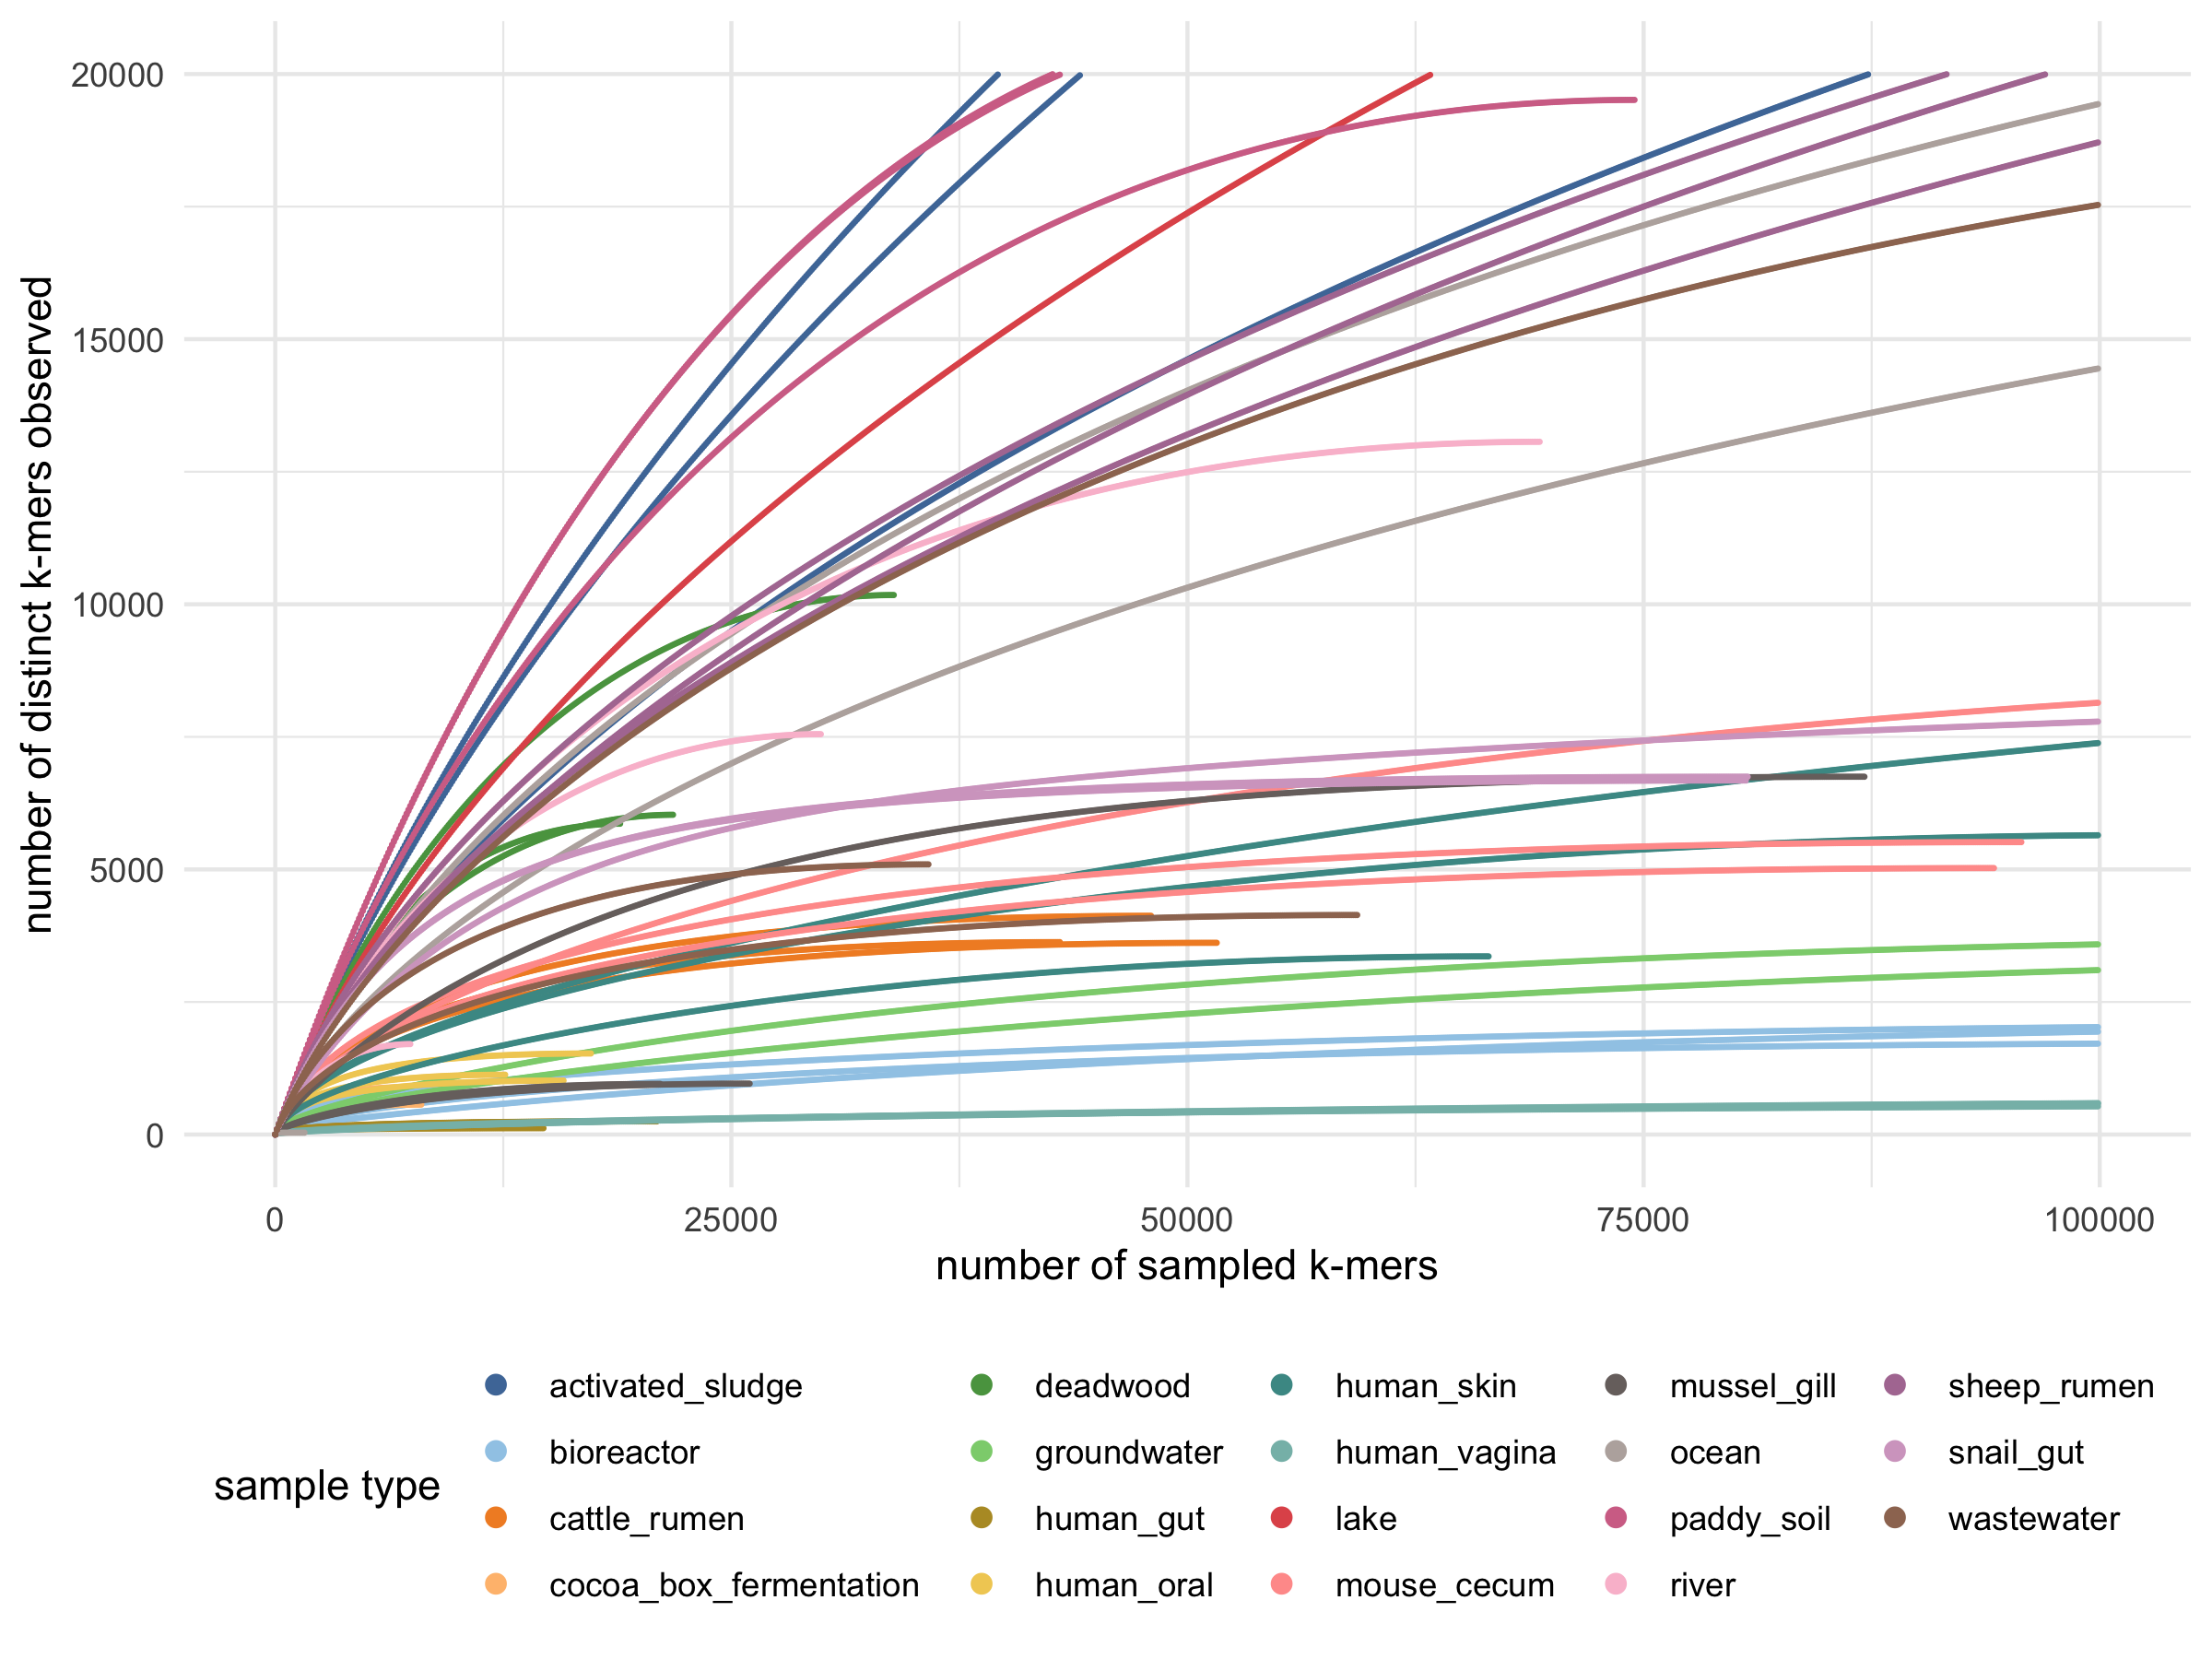

In [11]:
# subsample points more densely for zoomed viz
raw_rarecurve_filtered_100 <- raw_rarecurve %>%
  filter(num_kmers_sampled %% 100 == 1)

ggplot(raw_rarecurve_filtered_100, aes(x = num_kmers_sampled, y = num_kmers_observed, fill = mgx_run_accession, color = sample_type)) +
  geom_point(alpha = 1, size = .1) +
  theme_minimal() +
  theme(legend.position = "bottom") +
  guides(fill = "none", color = guide_legend(override.aes = list(size=2))) +
  scale_color_tableau(palette = "Tableau 20") +
  ylim(c(0, 20000)) + xlim(0, 100000) +
  labs(x = "number of sampled k-mers", y = "number of distinct k-mers observed", color = "sample type")

## promising sample types:

* snail gut
* human skin
* human vagina
* ground water
* human oral
* mussel gill
* mouse cecum
* cocoa box fermentation
* bioreactor
* cattle rumen -- which i'm deeply skeptical about

## After talking to adair, samples to move forward with:

* a rumen sample of some sort
* human skin
* look at vagina and see if any of them make senese
* activated sludge
* snail gut
* ground water
* cocoa box fermentation
* wastewater (most completely sequenced metagenome)
* mussel gill or ocean

## Select samples to move forward with

selection criteria are most deeply sequenced metagenome X leftover fraction of subtracted sample

In [12]:
sketch_describe <- Sys.glob("outputs/sourmash_sketch_describe/*csv") %>%
  map_dfr(read_csv, show_col_types = F) %>%
  mutate(run_accession = gsub(".sig", "", basename(signature_file)))

sketch_describe_mtx <- sketch_describe %>%
  filter(run_accession %in% metadata$mtx_run_accession) %>%
  select(mtx_run_accession = run_accession, ksize, mtx_n_hashes = n_hashes, mtx_sum_hashes = sum_hashes)

sketch_describe_mgx <- sketch_describe %>%
  filter(run_accession %in% metadata$mgx_run_accession) %>%
  select(mgx_run_accession = run_accession, ksize, mgx_n_hashes = n_hashes, mgx_sum_hashes = sum_hashes)

In [13]:
sketch_describe_subtract <- Sys.glob("outputs/sourmash_sketch_subtract_describe/*csv") %>%
  map_dfr(read_csv, show_col_types = F) %>%
  mutate(subtract_pair = gsub("\\-k[235]1\\.sig", "", basename(signature_file))) %>%
  select(subtract_pair, ksize, subtract_n_hashes = n_hashes, subtract_sum_hashes = sum_hashes)

In [14]:
sketch_describe_all <- metadata %>% inner_join(sketch_describe_subtract, by = "subtract_pair") %>%
  inner_join(sketch_describe_mtx, by = c("mtx_run_accession", "ksize")) %>%
  inner_join(sketch_describe_mgx, by = c("mgx_run_accession", "ksize"))

In [15]:
# calculate the fraction of the mtx left over after the mgx was subtracted
sketch_describe_all_frac <- sketch_describe_all %>%
  mutate(f_n_hashes = subtract_n_hashes / mtx_n_hashes,
         f_sum_hashes = subtract_sum_hashes / mtx_sum_hashes) %>%
  filter(ksize == 21) %>%
  filter(mgx_run_accession %in% slopes_filtered$mgx_run_accession) %>%
  filter(sample_type %in% c("snail_gut", "human_skin", "activated_sludge", "human_vagina", "groundwater",
                            "cocoa_box_fermentation", "mussel_gill", "ocean", "sheep_rumen", "cattle_rumen",
                            "wastewater")) %>%
  select(mgx_run_accession, sample_type, f_sum_hashes) %>%
  left_join(slopes_filtered)

Joining, by = c("mgx_run_accession", "sample_type")


In [17]:
sketch_describe_all_frac

mgx_run_accession,sample_type,f_sum_hashes,mean_slope,min_nonzero_slope,mtx_run_accession
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
SRR6032602,activated_sludge,0.14061619,0.099534161,1.112348e-07,SRR6032600
SRR6032601,activated_sludge,0.08297916,0.066933510,8.352072e-08,SRR6032604
SRR6032603,activated_sludge,0.13654471,0.103965884,1.106164e-07,SRR6032605
SRR8397917,cattle_rumen,0.14677208,0.085748742,1.102426e-06,SRR8416091
SRR8397912,cattle_rumen,0.23833264,0.084217368,1.197299e-06,SRR8416102
SRR8397925,cattle_rumen,0.22929991,0.070028283,8.202987e-07,SRR8416101
SRR4308227,groundwater,0.36183382,0.027874038,1.798912e-07,SRR4308224
SRR4308226,groundwater,0.15796846,0.020053070,1.067160e-07,SRR4308225
SRR1267595,sheep_rumen,0.14973980,0.059250753,7.759445e-08,SRR1138694


In [18]:
# if minimum slope is also the sample with the minimum f_sum_hashes (leftover distinct mtx), select that sample
samples <- c("SRR11781636", # snail gut
             "ERR3342496",  # mussel gill
             "ERR4073752",  # cocoa box fermentation
             "SRR17635491", # human vagina 1, low leftovers
             "SRR17635806", # human vagina 2, high leftovers
             "SRR9033715",  # human gut 1, lower leftovers (still really high)
             "SRR9033748",  # human gut 2, higher leftovers (very very high)
             "SRR4308226",  # groundwater
             "SRR6032601",  # activated sludge
             "ERR1191821",  # wastewater
             "SRR1230756",  # ocean
             "SRR873596")   # sheep rumen

In [20]:
sketch_describe_all_frac %>% filter(mgx_run_accession %in% samples) %>%
  arrange(f_sum_hashes) %>%
  mutate(sample_type = gsub("human_skin", "human_gut", sample_type)) # temporarily patch human skin labels for plotting

mgx_run_accession,sample_type,f_sum_hashes,mean_slope,min_nonzero_slope,mtx_run_accession
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
SRR11781636,snail_gut,0.04912285,0.020655011,1.699664e-08,SRR11781625
SRR17635491,human_vagina,0.05679432,0.003457493,1.331500e-08,SRR17858317
ERR3342496,mussel_gill,0.06302603,0.036883197,1.458412e-06,ERR3342476
ERR4073752,cocoa_box_fermentation,0.06496814,0.070088232,6.299966e-06,ERR4077214
SRR6032601,activated_sludge,0.08297916,0.066933510,8.352072e-08,SRR6032604
SRR873596,sheep_rumen,0.11259111,0.062428559,7.345807e-08,SRR873451
SRR1230756,ocean,0.14633633,0.084645480,1.988592e-07,SRR1230759
SRR4308226,groundwater,0.15796846,0.020053070,1.067160e-07,SRR4308225
ERR1191821,wastewater,0.15985281,0.142191207,2.742572e-06,ERR1198917


## reformat and plot assignable vs unknown fractions

In [28]:
plt_df <- sketch_describe_all_frac %>% 
  filter(mgx_run_accession %in% samples) %>%
  mutate(f_sum_hashes_mgx = 1 - f_sum_hashes) %>%
  select(mgx_run_accession, sample_type, f_sum_hashes_mtx = f_sum_hashes, f_sum_hashes_mgx) %>%
  pivot_longer(cols = f_sum_hashes_mtx:f_sum_hashes_mgx, names_to = "fraction_name", values_to = "fraction") %>%
  arrange(fraction) %>%
  mutate(plt_order = c(1:(nrow(.)/2), (nrow(.)/2):1)) %>%
  mutate(sample_type = gsub("human_skin", "human_gut", sample_type)) # temporarily patch human skin labels for plotting

In [29]:
plt_df

mgx_run_accession,sample_type,fraction_name,fraction,plt_order
<chr>,<chr>,<chr>,<dbl>,<int>
SRR11781636,snail_gut,f_sum_hashes_mtx,0.04912285,1
SRR17635491,human_vagina,f_sum_hashes_mtx,0.05679432,2
ERR3342496,mussel_gill,f_sum_hashes_mtx,0.06302603,3
ERR4073752,cocoa_box_fermentation,f_sum_hashes_mtx,0.06496814,4
SRR6032601,activated_sludge,f_sum_hashes_mtx,0.08297916,5
SRR873596,sheep_rumen,f_sum_hashes_mtx,0.11259111,6
SRR1230756,ocean,f_sum_hashes_mtx,0.14633633,7
SRR4308226,groundwater,f_sum_hashes_mtx,0.15796846,8
ERR1191821,wastewater,f_sum_hashes_mtx,0.15985281,9


Warning message:
“Using alpha for a discrete variable is not advised.”


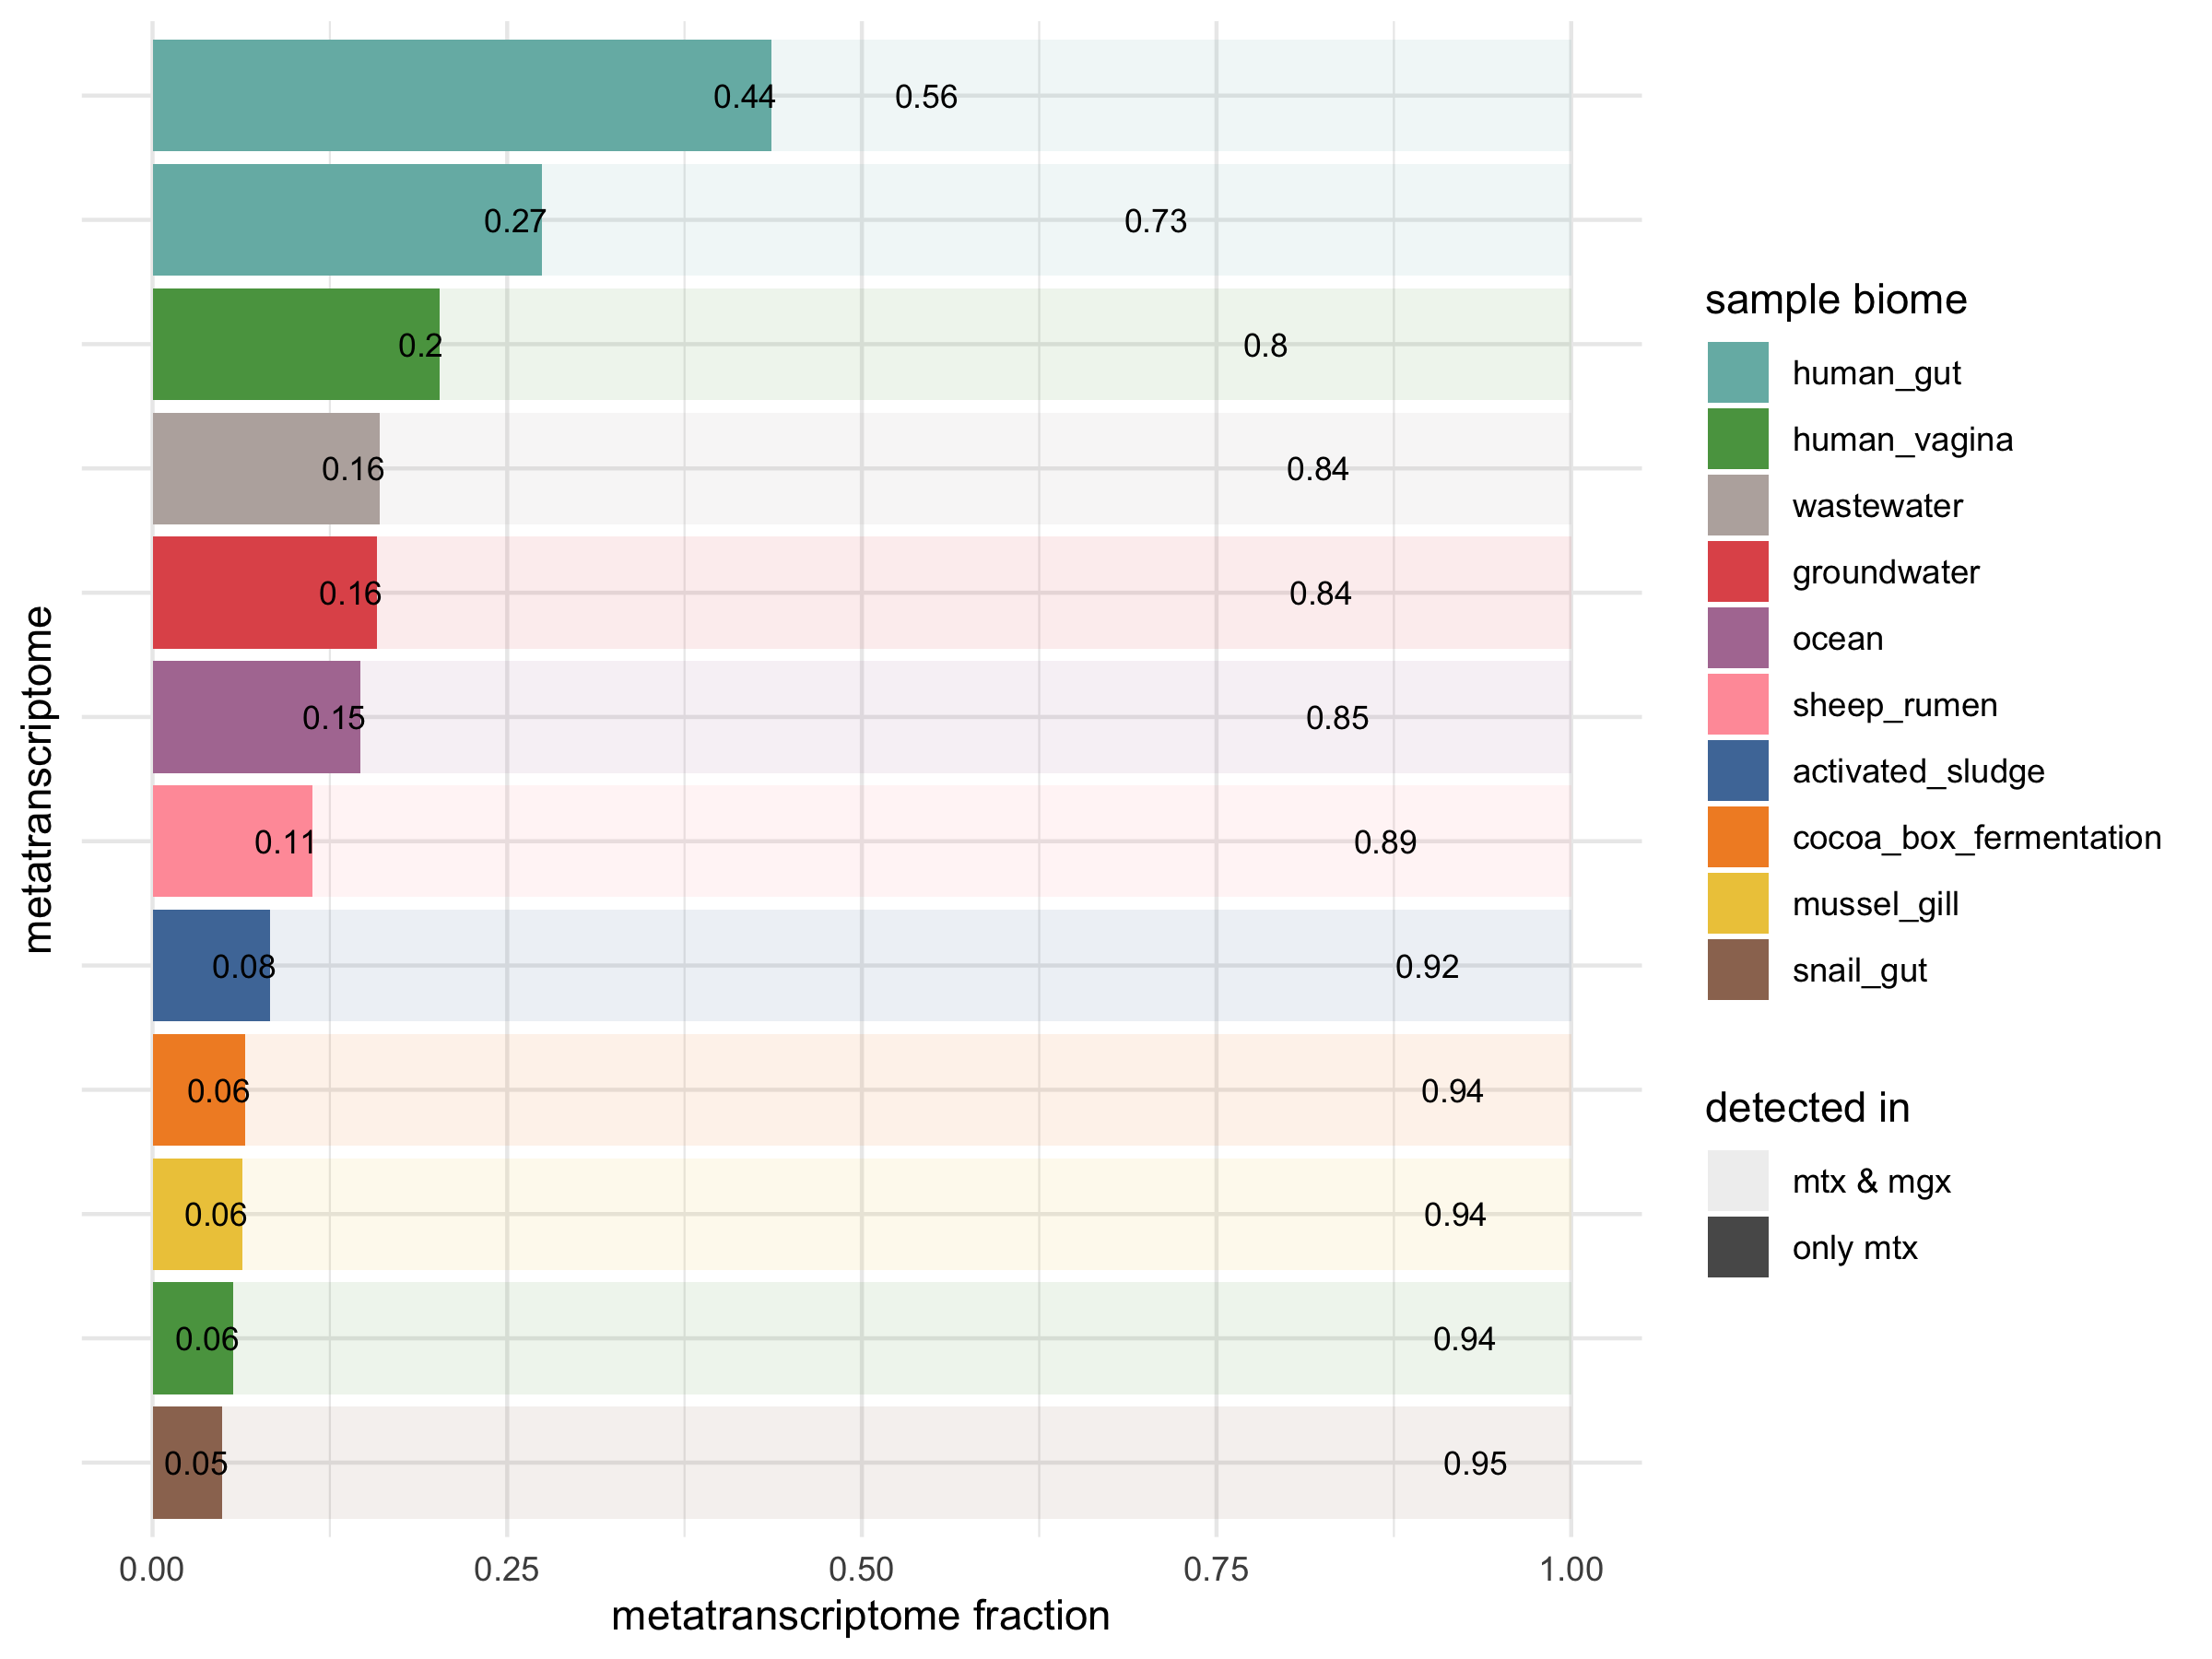

In [30]:
ggplot(plt_df, aes(x = reorder(mgx_run_accession, plt_order), y = fraction, alpha = fraction_name, fill = sample_type)) +
  geom_col() + 
  theme_minimal() +
  coord_flip() +
  geom_text(aes(label = round(fraction, digits = 2)), hjust = .9, size = 3, alpha = 1) +
  scale_fill_tableau(breaks = c("human_gut", "human_vagina", "wastewater", "groundwater", "ocean", 
                                "sheep_rumen", "activated_sludge", "cocoa_box_fermentation",
                                "mussel_gill", "snail_gut")) +
  labs(y = "metatranscriptome fraction", x = "metatranscriptome", fill = "sample biome", alpha = "detected in") +
  theme(axis.text.y = element_blank()) +
  scale_alpha_discrete(labels = c("f_sum_hashes_mgx" = "mtx & mgx", "f_sum_hashes_mtx" = "only mtx"))

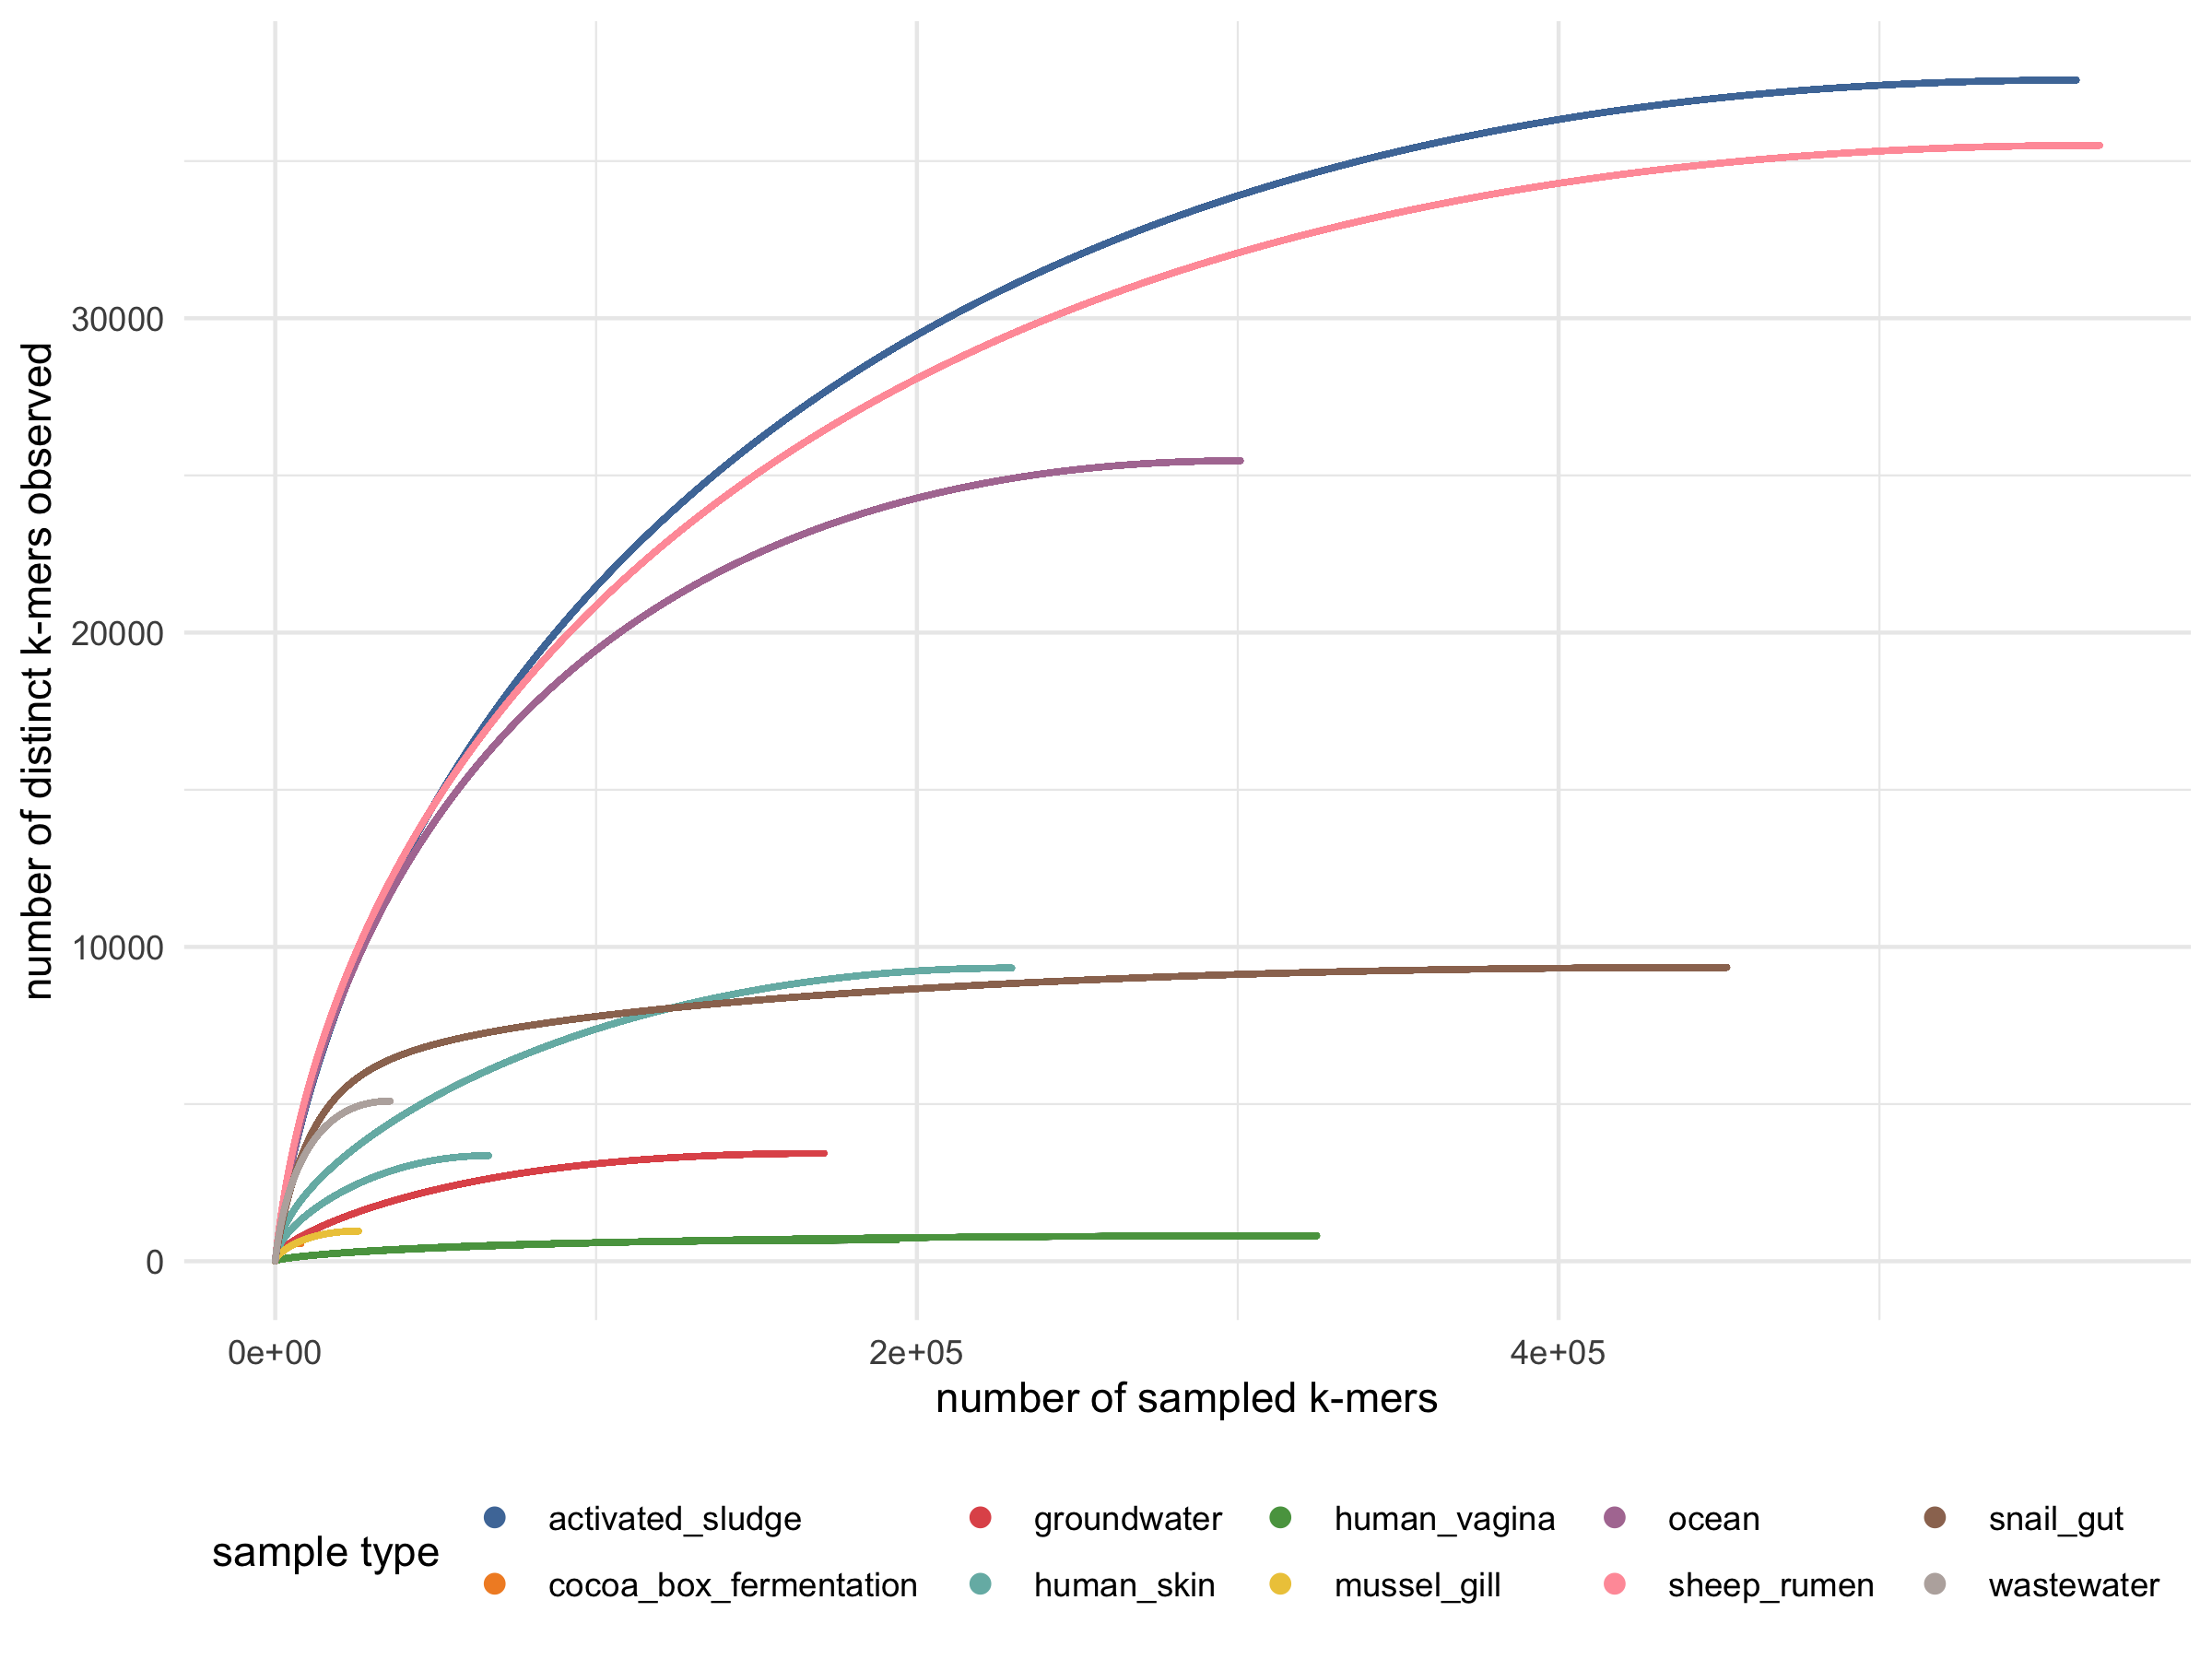

In [31]:
# plot matching rarefaction curves
# subsample points for visualization; grab only 1 every 500 points
raw_rarecurve_filtered_5 <- raw_rarecurve %>%
  filter(mgx_run_accession %in% samples) %>%
  filter(num_kmers_sampled %% 5 == 1)

plt <- ggplot(raw_rarecurve_filtered_5, aes(x = num_kmers_sampled, y = num_kmers_observed, fill = mgx_run_accession, color = sample_type)) +
  geom_point(alpha = 1, size = .1) +
  theme_minimal() +
  theme(legend.position = "bottom") +
  guides(fill = "none", color = guide_legend(override.aes = list(size=2))) +
  scale_color_tableau(palette = "Tableau 10") +
  labs(x = "number of sampled k-mers", y = "number of distinct k-mers observed", color = "sample type")

plt

## write out tsv with samples we'll move forward analyzing

In [39]:
metadata_selected_samples <- sketch_describe_all %>%
 filter(mgx_run_accession %in% samples) %>%
 left_join(slopes_filtered) %>%
   mutate(sample_type = gsub("human_skin", "human_gut", sample_type)) # temporarily patch human skin labels for plotting

Joining, by = c("mtx_run_accession", "mgx_run_accession", "sample_type")


In [40]:
metadata_selected_samples

sample_name,mtx_study_accession,mtx_run_accession,mgx_study_accession,mgx_run_accession,sample_type,subtract_pair,ksize,subtract_n_hashes,subtract_sum_hashes,mtx_n_hashes,mtx_sum_hashes,mgx_n_hashes,mgx_sum_hashes,mean_slope,min_nonzero_slope
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
B_2_1,PRJNA406858,SRR6032604,PRJNA406858,SRR6032601,activated_sludge,SRR6032604-minus-SRR6032601,21,3291625,20148366,4344693,242812377,40609163,295849948,0.066933510,8.352072e-08
B_2_1,PRJNA406858,SRR6032604,PRJNA406858,SRR6032601,activated_sludge,SRR6032604-minus-SRR6032601,31,4417228,24462033,5360132,243914611,45270528,272558269,0.066933510,8.352072e-08
B_2_1,PRJNA406858,SRR6032604,PRJNA406858,SRR6032601,activated_sludge,SRR6032604-minus-SRR6032601,51,5734327,27422840,6559940,169719257,45851648,226744558,0.066933510,8.352072e-08
HiTCEB12_2d,PRJNA344005,SRR4308225,PRJNA344005,SRR4308226,groundwater,SRR4308225-minus-SRR4308226,21,5876068,7649382,6102449,48423476,6619806,79058701,0.020053070,1.067160e-07
HiTCEB12_2d,PRJNA344005,SRR4308225,PRJNA344005,SRR4308226,groundwater,SRR4308225-minus-SRR4308226,31,6968356,9354221,7174962,88155659,8935090,83880221,0.020053070,1.067160e-07
HiTCEB12_2d,PRJNA344005,SRR4308225,PRJNA344005,SRR4308226,groundwater,SRR4308225-minus-SRR4308226,51,7796029,11424920,7969051,56341512,12093201,61948798,0.020053070,1.067160e-07
Tag1283-1,PRJNA202380,SRR873451,PRJNA202380,SRR873596,sheep_rumen,SRR873451-minus-SRR873596,21,1648732,2477502,4341723,22004419,58866918,319361902,0.062428559,7.345807e-08
Tag1283-1,PRJNA202380,SRR873451,PRJNA202380,SRR873596,sheep_rumen,SRR873451-minus-SRR873596,31,2072543,2948321,4634831,21478698,66775607,295139549,0.062428559,7.345807e-08
Tag1283-1,PRJNA202380,SRR873451,PRJNA202380,SRR873596,sheep_rumen,SRR873451-minus-SRR873596,51,2398792,3252743,4698416,16556736,70219274,245919000,0.062428559,7.345807e-08


In [41]:
write_tsv(metadata_selected_samples, "inputs/metadata-selected-samples.tsv")